## Visualize markers from Robin

In [1]:
# %pip install numpy pandas plotly nbformat scipy scikit-learn matplotlib pillow imageio

In [2]:
import numpy as np
from pathlib import Path

# Provide the folder path where the file is located
folder_path = Path.cwd().parent  # Replace with the actual folder path
print(f"Folder path: {folder_path}")
# cal_path = Path(folder_path).parent / 'cal'
# ori_files = cal_path.rglob('*.ori')

# Construct the full file path
file_paths = list(folder_path.rglob('markers*.txt'))
file_paths.sort()



Folder path: /home/user/Dropbox/3DPTV_Illmenau/Ilmenau_calibration_results


In [3]:
file_paths

[PosixPath('/home/user/Dropbox/3DPTV_Illmenau/Ilmenau_calibration_results/markers_c0.txt'),
 PosixPath('/home/user/Dropbox/3DPTV_Illmenau/Ilmenau_calibration_results/markers_c1.txt'),
 PosixPath('/home/user/Dropbox/3DPTV_Illmenau/Ilmenau_calibration_results/markers_c2.txt'),
 PosixPath('/home/user/Dropbox/3DPTV_Illmenau/Ilmenau_calibration_results/markers_c3.txt')]

In [4]:
import pandas as pd
from functools import reduce
import plotly.express as p

with open(file_paths[0], 'r') as f:
    header = f.readline().lstrip('#').strip().split(',')

# Read all marker files into a list of DataFrames
data_list = []
for fp in file_paths[:4]:
    with open(fp, 'r') as f:
        header = f.readline().lstrip('#').strip().split(',')
    df = pd.read_csv(fp, delim_whitespace=True, skiprows=1, names=[h.strip() for h in header])
    data_list.append(df)

# Merge on X, Y, Z (inner join, assuming these are the same across cameras)

# Add camera-specific x, y columns
for i, df in enumerate(data_list):
    df = df.rename(columns={'x': f'x_c{i}', 'y': f'y_c{i}'})
    data_list[i] = df[['X', 'Y', 'Z', f'x_c{i}', f'y_c{i}']]

# Merge all DataFrames on X, Y, Z
data = reduce(lambda left, right: pd.merge(left, right, on=['X', 'Y', 'Z'], how='inner'), data_list)

# Reorder columns: X, Y, Z, x_c0, y_c0, x_c1, y_c1, x_c2, y_c2, x_c3, y_c3
cols = ['X', 'Y', 'Z']
for i in range(4):
    cols.extend([f'x_c{i}', f'y_c{i}'])
data = data[cols]


data.head()
# print(data)

/tmp/ipykernel_46342/289924782.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, delim_whitespace=True, skiprows=1, names=[h.strip() for h in header])
/tmp/ipykernel_46342/289924782.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, delim_whitespace=True, skiprows=1, names=[h.strip() for h in header])
/tmp/ipykernel_46342/289924782.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, delim_whitespace=True, skiprows=1, names=[h.strip() for h in header])
/tmp/ipykernel_46342/289924782.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
 

,X,Y,Z,x_c0,y_c0,x_c1,y_c1,x_c2,y_c2,x_c3,y_c3
0,-0.0,2627.13,0.0,1408.154175,521.524658,1504.386597,706.947937,2106.627197,645.244080,2102.783447,654.626892
1,-40.0,2627.13,0.0,1424.571289,515.204163,1523.284912,708.784302,2125.145508,645.690063,2123.102539,653.300964
2,-80.0,2627.13,0.0,1440.942017,508.894867,1542.594604,710.381348,2144.040039,645.866577,2143.699951,652.146301
3,-120.0,2627.13,0.0,1457.651245,502.401489,1561.905762,712.209534,2162.951416,646.077026,2164.219238,651.067993
4,-160.0,2627.13,0.0,1474.573364,496.089600,1581.655518,714.033752,2181.904053,646.245361,2184.876221,649.897156


In [5]:
import plotly.graph_objs as go

# Extract X, Y, Z columns
X = data['X']
Y = data['Y']
Z = data['Z']

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=X, y=Y, z=Z,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Markers'
)])

# Set axis labels: Y upwards, Z depth, X left-right
fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)'
    ),
    title='3D Scatter Plot of Markers'
)

fig.show()


In [6]:
import numpy as np

def farthest_point_sampling(X, Y, Z, n_samples=10, seed=None):
    rng = np.random.default_rng(seed)
    points = np.stack([X.values, Y.values, Z.values], axis=1)
    n_points = points.shape[0]
    selected_indices = []
    # Start with a random point
    idx = rng.integers(n_points)
    selected_indices.append(idx)
    # Compute distances to the first point
    dists = np.linalg.norm(points - points[idx], axis=1)
    for _ in range(1, n_samples):
        idx = np.argmax(dists)
        selected_indices.append(idx)
        # Update distances: for each point, keep the minimum distance to any selected point
        dists = np.minimum(dists, np.linalg.norm(points - points[idx], axis=1))
    return selected_indices

# Example usage:
fps_indices = farthest_point_sampling(X, Y, Z, n_samples=10, seed=42)
sampled_fps = data.loc[fps_indices, [f'x_c{i}' for i in range(4)] + [f'y_c{i}' for i in range(4)] + ['X', 'Y', 'Z']]
sampled_fps

,x_c0,x_c1,x_c2,x_c3,y_c0,y_c1,y_c2,y_c3,X,Y,Z
4173,1841.083618,2068.886475,2317.863525,2356.161865,342.585327,435.130676,596.021973,380.292603,-761.424500,3197.426265,831.336304
42126,281.233124,389.029266,302.306183,528.184814,1670.689087,1317.855347,1534.966675,1621.111084,4069.469482,242.680049,-74.552307
45347,1555.692383,1511.730225,1566.735596,1593.872803,1583.878418,1302.658813,1600.780762,1260.097656,1161.550415,218.431758,2679.383789
11051,953.338806,992.239563,1087.765625,971.199829,763.185791,378.583466,641.070679,425.262451,3069.834961,3485.043635,1809.926025
35623,959.752380,981.197632,1648.066772,1657.807617,1393.389526,1472.919312,1385.351196,1507.190918,968.571960,866.650996,-398.552368
1666,301.029266,224.260437,899.113586,669.074158,500.893890,359.042786,157.941208,441.747162,2600.340088,3198.724971,-1036.316650
39490,2388.394043,2252.777832,2466.125000,2394.975830,1392.214478,1496.198853,1555.698486,1224.160034,-1380.407715,700.294185,1770.901611
9665,1560.301514,1644.777954,1679.955200,1655.712646,869.080688,638.996277,931.201904,616.226562,855.187439,2707.766955,2634.646240
46750,952.994324,979.608032,987.094421,1029.978149,1377.765991,1035.829834,1297.847778,1129.237183,3164.186523,1046.318965,1865.443481
16983,1041.453613,1079.637695,1383.228271,1345.862061,913.100952,760.124207,860.267761,797.190979,1747.421875,2321.419612,792.281067


In [7]:
import plotly.graph_objs as go

# Plot all points in blue
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X, y=Y, z=Z,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='All Markers'
))

# Plot random sampled points (fps_indices) in red
sampled_fps = data.loc[fps_indices, ['X', 'Y', 'Z']]
fig.add_trace(go.Scatter3d(
    x=sampled_fps['X'], y=sampled_fps['Y'], z=sampled_fps['Z'],
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Random Sampled Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)'
    ),
    title='3D Scatter Plot with Random Sampled Points Highlighted'
)

fig.show()

In [8]:
# Prepare data for saving: running index (0-based), X, Y, Z for fps_indices
calib_block = sampled_fps.reset_index(drop=True)
calib_block.insert(0, 'idx', range(len(calib_block)))

# Save to tab-delimited text file
calib_block[['idx', 'X', 'Y', 'Z']].to_csv('calibration_block.txt', sep='\t', index=False, header=False, float_format='%.8f')

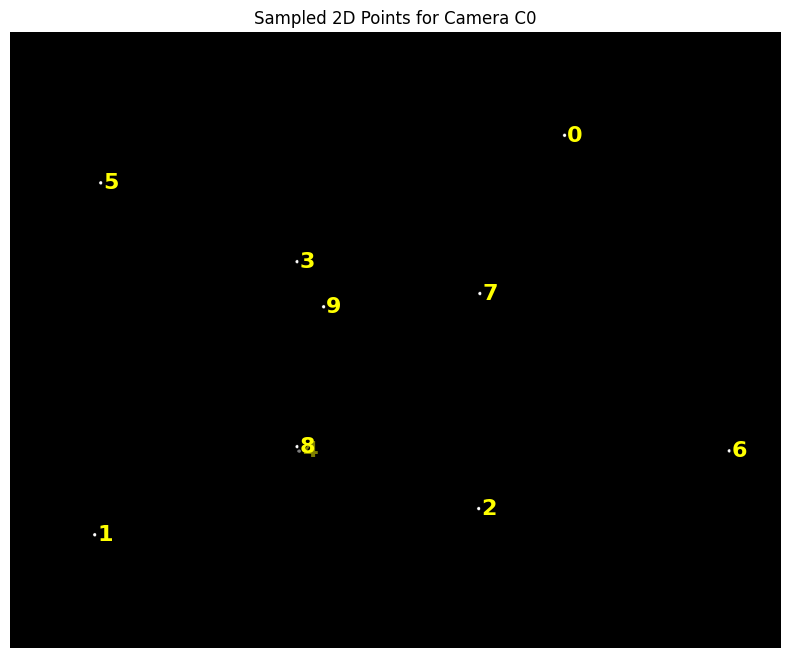

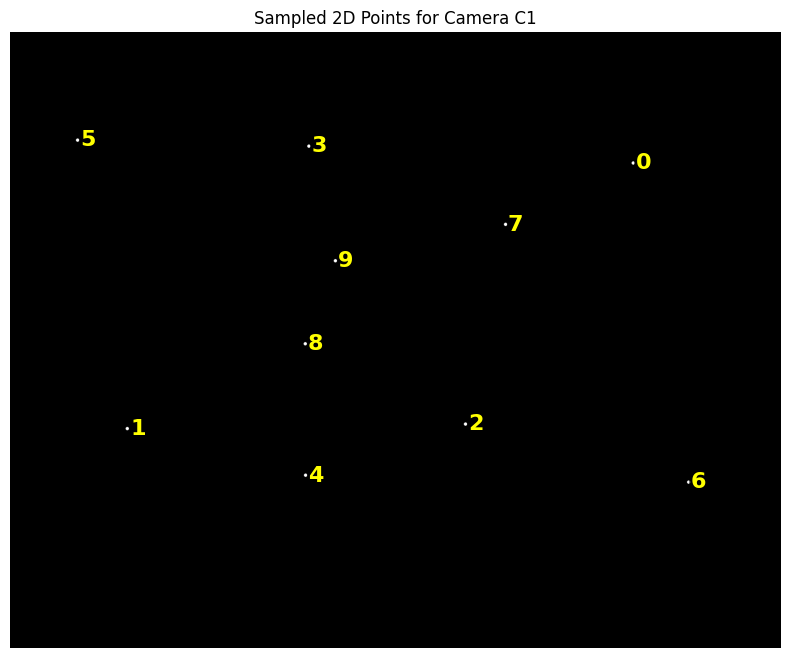

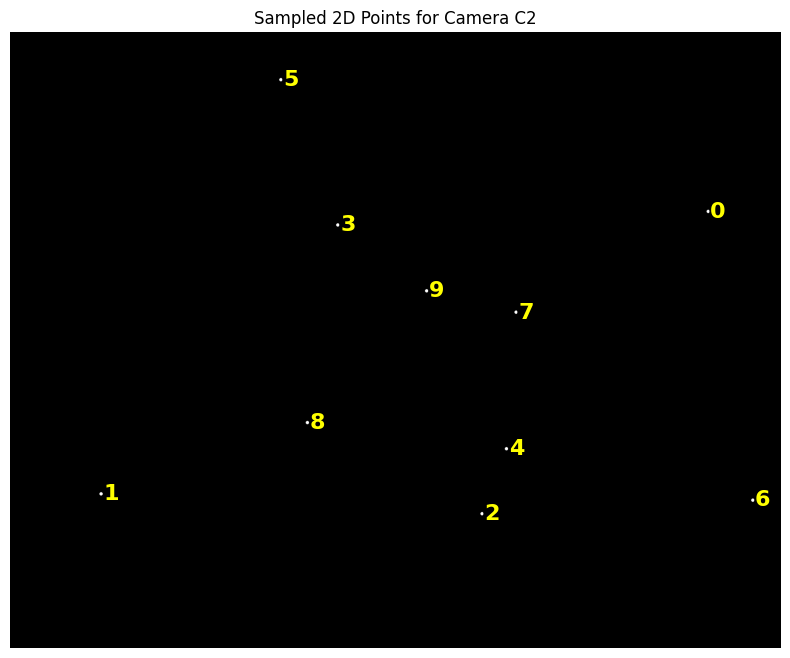

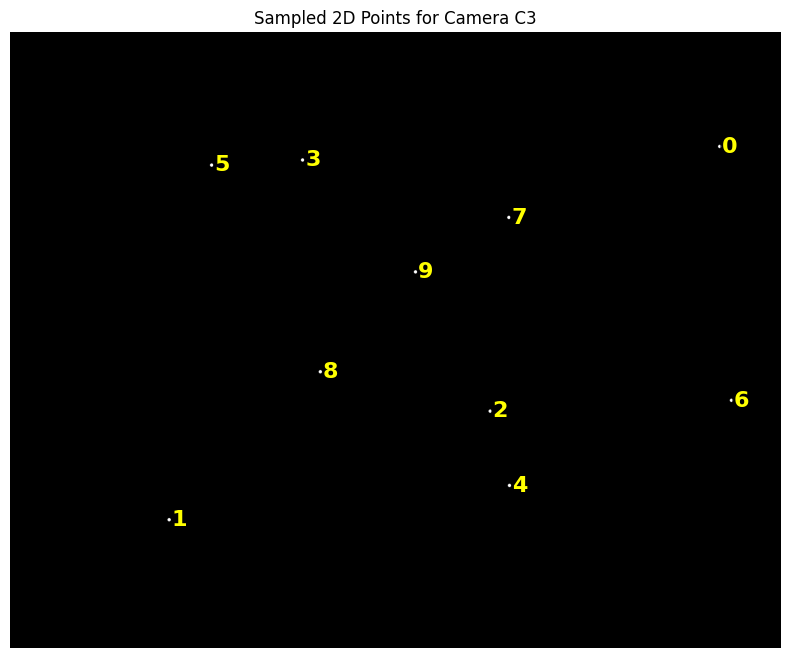

In [9]:
from PIL import Image, ImageDraw
import imageio.v3 as imageio
import matplotlib.pyplot as plt

# Camera names and corresponding columns
camera_names = ['c0', 'c1', 'c2', 'c3']

for i, cam in enumerate(camera_names):
    img = Image.new('L', (2560, 2048), 0)
    draw = ImageDraw.Draw(img)
    # Get x, y for this camera from sampled_fps indices
    xy_points = data.loc[fps_indices, [f'x_{cam}', f'y_{cam}']].values
    xy_points = np.round(xy_points).astype(int)
    for x, y in xy_points:
        if 0 <= x < 2560 and 0 <= y < 2048:
            draw.ellipse((x-5, y-5, x+5, y+5), fill=255)
    # Show image
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.title(f'Sampled 2D Points for Camera {cam.upper()}')
    plt.axis('off')
    # Add running number (idx) next to each point
    for j, (x, y) in enumerate(xy_points):
        plt.text(x + 10, y, str(j), color='yellow', fontsize=16, fontweight='bold', va='center', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
    plt.show()
    # Save image
    imageio.imwrite(f'{cam}.tif', np.array(img))



In [14]:
# Provide the folder path where the file is located
pyptv_folder = Path.cwd().parent / 'pyptv'
folder_path = pyptv_folder / 'res'  # Replace with the actual folder path
cal_path = pyptv_folder / 'cal'
ori_files = cal_path.rglob('*.ori')

# Construct the full file path
file_path = f'{folder_path}/rt_is.123456789'

# Read the file using numpy
data = np.loadtxt(file_path, skiprows=1)

import plotly.graph_objs as go
import plotly.express as px

# Filter the rows where the last column is not -1
filtered_data = data[np.sum(data[:, -4:] == -1, axis=1) < 3]

# Extract the columns for the 3D scatter plot from the filtered data
x = filtered_data[:, 1]
y = filtered_data[:, 2]
z = filtered_data[:, 3]



# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])

# Set plot title and labels
fig.update_layout(title='3D Scatter Plot', scene=dict(
    xaxis_title='Z',
    yaxis_title='X',
    zaxis_title='Y'
))


for f in ori_files:
    with open(f, 'r') as file:
        # Read the first line for camera position
        cam_pos = np.array(file.readline().strip().split(), dtype=float)
        # Read the second line for camera angles
        cam_angles = np.array(file.readline().strip().split(), dtype=float)
    
    # Calculate the direction vector from the angles
    direction = np.array([
        np.cos(cam_angles[1]) * np.cos(cam_angles[0]),
        np.sin(cam_angles[1]),
        np.cos(cam_angles[1]) * np.sin(cam_angles[0])
    ])
    
    # Plot the camera position
    fig.add_trace(go.Scatter3d(
        x=[cam_pos[0]], y=[cam_pos[1]], z=[cam_pos[2]],
        mode='markers',
        marker=dict(size=5, color='red'),
        name='Camera Position'
    ))
    
    # Plot the direction arrow
    fig.add_trace(go.Scatter3d(
        x=[cam_pos[0], cam_pos[0] + direction[0]],
        y=[cam_pos[1], cam_pos[1] + direction[1]],
        z=[cam_pos[2], cam_pos[2] + direction[2]],
        mode='lines',
        line=dict(color='red', width=5),
        name='Camera Direction'
    ))


fig.add_trace(go.Scatter3d(
    x=calib_block['X'],
    y=calib_block['Y'],
    z=calib_block['Z'],
    mode='markers+text',
    marker=dict(size=6, color='red', opacity=0.8),
    text=calib_block['idx'].astype(str),
    textposition='top center',
    name='Calibration Block Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5),  # view from above front-right
            up=dict(x=0, y=1, z=0),         # y is up
            center=dict(x=0, y=0, z=0)
        )
    ),
    title='3D Scatter Plot of Calibration Block Points with Indices'
)



# Show the plot
fig.show()


In [11]:
import plotly.graph_objs as go

# 3D scatter plot of calibration block points with idx labels
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=calib_block['X'],
    y=calib_block['Y'],
    z=calib_block['Z'],
    mode='markers+text',
    marker=dict(size=6, color='red'),
    text=calib_block['idx'].astype(str),
    textposition='top center',
    name='Calibration Block Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (left-right)',
        yaxis_title='Y (upwards)',
        zaxis_title='Z (depth)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5),  # view from above front-right
            up=dict(x=0, y=1, z=0),         # y is up
            center=dict(x=0, y=0, z=0)
        )
    ),
    title='3D Scatter Plot of Calibration Block Points with Indices'
)

fig.show()

In [16]:
calib_block['X'],calib_block['Y'],calib_block['Z']

(0    -761.424500
 1    4069.469482
 2    1161.550415
 3    3069.834961
 4     968.571960
 5    2600.340088
 6   -1380.407715
 7     855.187439
 8    3164.186523
 9    1747.421875
 Name: X, dtype: float64,
 0    3197.426265
 1     242.680049
 2     218.431758
 3    3485.043635
 4     866.650996
 5    3198.724971
 6     700.294185
 7    2707.766955
 8    1046.318965
 9    2321.419612
 Name: Y, dtype: float64,
 0     831.336304
 1     -74.552307
 2    2679.383789
 3    1809.926025
 4    -398.552368
 5   -1036.316650
 6    1770.901611
 7    2634.646240
 8    1865.443481
 9     792.281067
 Name: Z, dtype: float64)

In [27]:
calib_block, df 

(   idx            X            Y            Z
 0    0  -761.424500  3197.426265   831.336304
 1    1  4069.469482   242.680049   -74.552307
 2    2  1161.550415   218.431758  2679.383789
 3    3  3069.834961  3485.043635  1809.926025
 4    4   968.571960   866.650996  -398.552368
 5    5  2600.340088  3198.724971 -1036.316650
 6    6 -1380.407715   700.294185  1770.901611
 7    7   855.187439  2707.766955  2634.646240
 8    8  3164.186523  1046.318965  1865.443481
 9    9  1747.421875  2321.419612   792.281067,
      ID         X         Y         Z    i    j    k    l
 0   1.0   861.723  2701.149  2610.624  3.0  3.0  4.0  3.0
 1   2.0  3122.594  1063.382  1829.098  5.0  5.0  5.0  5.0
 2   3.0  1148.487   240.745  2641.245  8.0  6.0  9.0  7.0
 3   4.0  1743.363  2320.908   790.056  4.0  4.0  3.0  4.0
 4   5.0  -757.524  3196.980   853.086  0.0  2.0  1.0  0.0
 5   6.0  3056.435  3473.787  1802.472  2.0  1.0  2.0  1.0
 6   7.0  4062.387   243.678   -77.662  9.0  7.0  7.0  9.0
 7   8.0  

In [23]:
df  = pd.DataFrame.from_records(filtered_data,columns=['ID','X', 'Y', 'Z', 'i','j','k','l'])

In [28]:
from numpy import isclose

# Find the order of rows in df that matches the order of rows in calib_block based on X, Y, Z

order = []
for _, row in calib_block.iterrows():
    # Find the index in df where X, Y, Z match (allowing for floating point tolerance)
    mask = (isclose(df['X'], row['X'], atol=50)) & \
           (isclose(df['Y'], row['Y'], atol=50)) & \
           (isclose(df['Z'], row['Z'], atol=50))
    idxs = df[mask].index
    if len(idxs) > 0:
        order.append(idxs[0])
    else:
        order.append(None)  # or handle as needed

order  # This list gives the indices in df that match the order of calib_block

[np.int64(4),
 np.int64(6),
 np.int64(2),
 np.int64(5),
 np.int64(7),
 np.int64(9),
 np.int64(8),
 np.int64(0),
 np.int64(1),
 np.int64(3)]

In [29]:
# Reorder df according to the found order (ignoring None values)
df_ordered = df.loc[order].reset_index(drop=True)

# Compare the coordinates in calib_block and df_ordered
comparison = pd.DataFrame({
    'calib_X': calib_block['X'],
    'df_X': df_ordered['X'],
    'calib_Y': calib_block['Y'],
    'df_Y': df_ordered['Y'],
    'calib_Z': calib_block['Z'],
    'df_Z': df_ordered['Z']
})

# Calculate differences
comparison['diff_X'] = comparison['calib_X'] - comparison['df_X']
comparison['diff_Y'] = comparison['calib_Y'] - comparison['df_Y']
comparison['diff_Z'] = comparison['calib_Z'] - comparison['df_Z']

comparison

,calib_X,df_X,calib_Y,df_Y,calib_Z,df_Z,diff_X,diff_Y,diff_Z
0,-761.424500,-757.524,3197.426265,3196.980,831.336304,853.086,-3.900500,0.446265,-21.749696
1,4069.469482,4062.387,242.680049,243.678,-74.552307,-77.662,7.082482,-0.997951,3.109693
2,1161.550415,1148.487,218.431758,240.745,2679.383789,2641.245,13.063415,-22.313242,38.138789
3,3069.834961,3056.435,3485.043635,3473.787,1809.926025,1802.472,13.399961,11.256635,7.454025
4,968.571960,961.055,866.650996,856.292,-398.552368,-403.399,7.516960,10.358996,4.846632
5,2600.340088,2625.579,3198.724971,3208.971,-1036.316650,-1025.360,-25.238912,-10.246029,-10.956650
6,-1380.407715,-1384.288,700.294185,689.355,1770.901611,1809.948,3.880285,10.939185,-39.046389
7,855.187439,861.723,2707.766955,2701.149,2634.646240,2610.624,-6.535561,6.617955,24.022240
8,3164.186523,3122.594,1046.318965,1063.382,1865.443481,1829.098,41.592523,-17.063035,36.345481
9,1747.421875,1743.363,2321.419612,2320.908,792.281067,790.056,4.058875,0.511612,2.225067


In [30]:
import numpy as np

# Compute the sum of squared differences for X, Y, Z columns
squared_diffs = (calib_block[['X', 'Y', 'Z']].values - df_ordered[['X', 'Y', 'Z']].values) ** 2
ls_distance = np.sqrt(np.sum(squared_diffs))

print(f"Least squares distance between the two datasets: {ls_distance:.4f}")

Least squares distance between the two datasets: 98.8446
